In [1]:
#copy a small ttgamma and ttbar file locally
!xrdcp root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/TTGamma_1l.root .
!xrdcp root://cmseos.fnal.gov//store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles/TTbar_1l.root .
    

[449.4MB/449.4MB][100%][==================================================][112.4MB/s]  
[547.6MB/547.6MB][100%][==================================================][136.9MB/s]  


NOTE: Need to update filepaths to point to 2021 area!!!

In [3]:
from coffea import hist, util
from coffea.analysis_objects import JaggedCandidateArray

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward1 as ak


The code below introduces some basic concepts for writing code using Coffea.  

There are three primary pieces to the Coffea code:  
1. The *processor*, which contains all of the analysis cuts and fills the histogram in the _process_ function. 
2. The second cell defines the files we want to run over and then runs the code using run_uproot_job. 
3. After we run the processor, we can then plot any of the histograms we have generated.

To test any changes you make to the histograms, you will have to rerun each of the three cells below.

In [4]:
class TTGammaCutflow(processor.ProcessorABC):
    def __init__(self):
        ### This function is where the histograms are defined and any other initialization happens
        
        ### Muon pt
        #Declare an axis for the dataset
        dataset_axis = hist.Cat("dataset","Dataset")
        
        #Declare an axis for the muon pt
        muon_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 200)
        

        #Define the accumulator object, a dictionary storing all of the histograms and counters 
        #that we will fill later in the process function
        self._accumulator = processor.dict_accumulator({
            'muon_pt': hist.Hist("Counts", dataset_axis, muon_pt_axis),
        }
        )
    
        ######
        ### Step 1. Add a histogram for the electron pt
        ######
        
        ######

        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        ## This gets us the accumulator dictionary we defined in init
        output = self.accumulator.identity()

        ## To access variables from the ntuples, use the "events" object
        ## The dataset name is part of events.metadata
        dataset = events.metadata['dataset']
        
        ## The coffea NanoEventSchema packages all muon variables (columns) into the events.Muon object
        ## Each variable can be accessed using muons.key_name
        muons = events.Muon        
        
        ######
        
        # Select muons with pt >30, eta < 2.4, tight ID, and relIso < 0.15
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )

        # Apply the selection to muons using the array[mask] syntax. 
        # tightMuons only includes the muons that pass the tight selection we defined
        tightMuons = muons[muonSelectTight]
        
        ######
        ### Step 2. Define your own selection for electrons. 
        ### Note that the ID variable names will be different. 
        ### Either remove the ID and iso variables or replace them with the correct electron values.
        ###### 
        
        
        ######
        
        # Select events with exactly one tight muon. 
        eventSelection = (ak.num(tightMuons)==1)
        
        ######
        ### Step 3. Define a second event selection requiring events with no muons and exactly one electron
        ###### 
        
        
        ######

        # Fill the muon_pt histogram using the tightMuons in events that pass our selection 
        # Note that ak.flatten() is required when filling a histogram to remove the jaggedness
        output['muon_pt'].fill(dataset=dataset,
                              pt=ak.flatten(tightMuons[eventSelection].pt))
        
        ######
        ### Step 4. Fill the ele_pt histogram you defined earlier
        ###### 
        
        
        ######
        
        
        
        return output

    def postprocess(self, accumulator):
        return accumulator


In [5]:
#Define files to run over
fileset = {"TTGamma":["TTGamma_1l.root"],
           "TTbar":["TTbar_1l.root"],
          }

#Run Coffea code using uproot
output = processor.run_uproot_job(
    fileset,
    "Events",
    TTGammaCutflow(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)

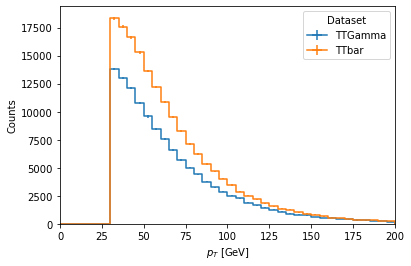

In [7]:
# Plot the muon_pt histogram, overlaying the distribution for each dataset
hist.plot1d(output['muon_pt'],overlay='dataset')

######
### Step 5. Plot the ele_pt histogram
###### 
        
######

If you want to look at other files, feel free to edit _fileset_ above using the skimmed datasets here: /store/user/cmsdas/2020/long_exercises/TTGamma/TestFiles

Now that you've seen some of the basics of histogramming, object cuts, and event selection, let's go through how to apply weights to the histograms.

In [40]:
import uproot
import numpy as np

import os.path
cwd = os.getcwd()

from coffea.lookup_tools import dense_lookup

class TTGammaWeights(processor.ProcessorABC):
    def __init__(self):
        
        # There are several utilities within coffea that can help us apply weights and systematics to the code
        # We use uproot to open the root file containing the electron ID scale factors:
        ele_id_file = uproot.open(f'{cwd}/ttgamma/ScaleFactors/MuEGammaScaleFactors/ele2016/2016LegacyReReco_ElectronTight_Fall17V2.root')
        # The dense_lookup tools in Coffea make it easy to extract the histogram (named EGamma_SF2D in this case)
        # with the weights and their errors:
        self.ele_id_sf = dense_lookup.dense_lookup(ele_id_file["EGamma_SF2D"].values, ele_id_file["EGamma_SF2D"].edges)
        self.ele_id_err = dense_lookup.dense_lookup(ele_id_file["EGamma_SF2D"].variances**0.5, ele_id_file["EGamma_SF2D"].edges)

        dataset_axis = hist.Cat("dataset", "Dataset")

        # The systematic axis will be used to keep track of whether we are using the nominal weights
        # or the weights shifted up/down by their errors
        systematic_axis = hist.Cat("systematic", "Systematic Uncertainty")
        ele_pt_axis = hist.Bin("pt","$p_{T}$ [GeV]", 40, 0, 200)

        self._accumulator = processor.dict_accumulator({
            'ele_pt': hist.Hist("Counts", dataset_axis, systematic_axis, ele_pt_axis)
        }
        )
        
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):

        output = self.accumulator.identity()

        dataset = events.metadata['dataset']

        electrons = events.Electron
        
        #Define tight electron selection
        electronSelectTight = ((electrons.pt>35) & 
                               (abs(electrons.eta)<2.1) & 
                               (abs(electrons.eta) < 1.4442) | (abs(electrons.eta) > 1.566) &      
                               (electrons.cutBased>=4)
                              )
        # Apply selection
        tightElectron = electrons[electronSelectTight]
        #Define event selection
        eventSelection = (ak.num(tightElectron) ==1)


        # Here, we look up the scale factors and errors for each electron using the electron eta and pt
        eleID = self.ele_id_sf(tightElectron.eta, tightElectron.pt)
        eleIDerr = self.ele_id_err(tightElectron.eta, tightElectron.pt)
        
        #To get an event-level weight, multiply the SF for each electron in the event
        #The axis=-1 option means we are multiplying the innermost values (electrons per event in this case)
        eleSF = ak.prod(eleID, axis=-1)
        eleSFUp = ak.prod(eleID+eleIDerr, axis=-1)
        eleSFDown = ak.prod(eleID-eleIDerr, axis=-1)
    
        # The processor.Weights object is a container that handles the bookkeeping 
        # for event weights and associated systematic shifts.
        # The argument for the Weights object is the number of events we are processing
        weights = processor.Weights(len(events))

        # Add the ele ID SF to the weights object
        weights.add('eleEffWeight',weight=eleSF,weightUp=eleSFUp,weightDown=eleSFDown)
        
        systList = ['noweight','nominal','eleEffWeightUp','eleEffWeightDown']

        for syst in systList:
           
            weightSyst = syst
            if syst=='nominal':
                weightSyst=None
                
            if syst=='noweight':
                evtWeight = np.ones(len(events))
            else:
                evtWeight = weights.weight(weightSyst)
                
            output['ele_pt'].fill(dataset=dataset,
                                  systematic=syst,
                                  pt=ak.flatten(tightElectron[eventSelection].pt),
                                  weight=evtWeight[eventSelection])
           
        return output

    def postprocess(self, accumulator):
        return accumulator

In [41]:
#Define files to run over
fileset = {"TTGamma":["TTGamma_1l.root"]
          }


#Run Coffea code using uproot
output = processor.run_uproot_job(
    fileset,
    "Events",
    TTGammaWeights(),
    processor.iterative_executor,
    {"schema": NanoAODSchema},
)

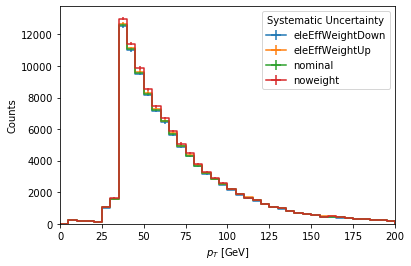

In [42]:
# Plot the pt distributions for each of the different systematics
hist.plot1d(output['ele_pt'].sum('dataset'),overlay='systematic')